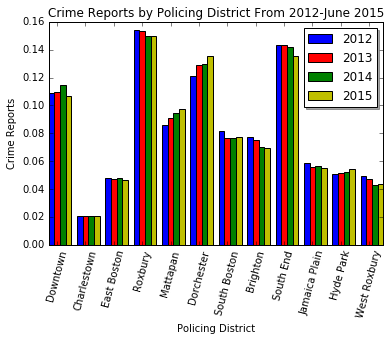

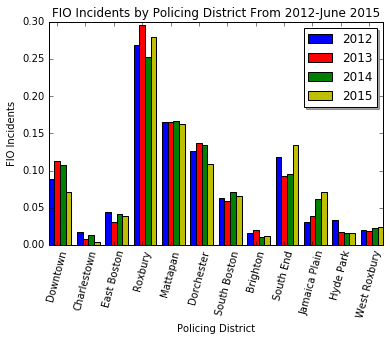

              Crime Incident Perc. Change     FIOs Incident Perc. Change
Downtown             -0.3036                    -2.9575
Charlestown          -0.0937                    -15.6335
East Boston          -0.7049                    -0.7786
Roxbury              -0.7041                    1.4347
Mattapan              3.2097                    -0.3844
Dorchester            2.9223                    -3.1003
South Boston         -1.2953                    1.7334
Brighton             -2.6905                    -2.1832
South End            -1.4154                    5.4872
Jamaica Plain        -1.4385                    24.7204
Hyde Park             1.8655                    -13.0635
West Roxbury         -3.0339                    5.5475


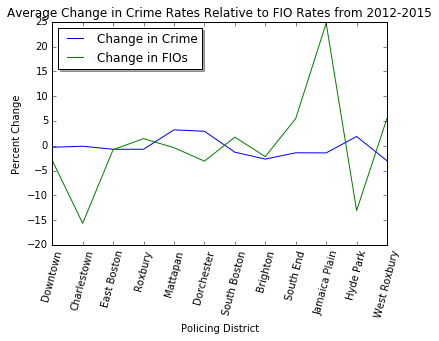

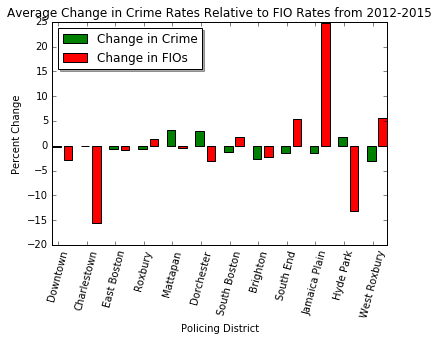

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections
import sys



# Visual Modules

from IPython.display import display, HTML
%matplotlib inline

# Define a helpful global list of Boston's policing districts
DISTRICTS = ['Downtown', 'Charlestown', 'East Boston', 'Roxbury', 'Mattapan', 'Dorchester', 'South Boston', \
        'Brighton', 'South End', 'Jamaica Plain', 'Hyde Park', 'West Roxbury']

# First, we read in our original .csv files, and edit the tables so as to be usable for our plotting.
df_fios = pd.read_csv('datasets/bpd-field-interrogation-and-observation-reports.csv', dtype=str).fillna('')
df = pd.read_csv('datasets/crime-indicent-reports-2012-2015.csv', dtype=str).fillna('')

# Now, lets discretize the timestamp into a year attribute, in order to group each FIO by the year in which it occured.
years = []
for entry in df_fios.FIO_DATE:
    curr_year = entry[6:10]
    years.append(curr_year)

df_fios['Year'] = pd.Series(years, index=df_fios.index) # Append our newly created column to our DataFrame.


# Examine how crime levels have changed within each Boston Policing district over the years
districts = df_fios['DIST'].unique()
districts= [dist for dist in sorted(districts) if dist in ['A1', 'A15', 'A7', 'B2', 'B3', 'C11', \
                                                                      'C6', 'D14', 'D4', 'E13', 'E18', 'E5']]

# First lets group by the Year attribute we just created for our FIO data
df_fios_by_year = df_fios.groupby('Year')
df_fios2012 = df_fios_by_year.get_group('2012')
df_fios2013 = df_fios_by_year.get_group('2013')
df_fios2014 = df_fios_by_year.get_group('2014')
df_fios2015 = df_fios_by_year.get_group('2015')

# Filter out the unnecessary districts (some have very few entries/aren't major policing districts)
fios_counts2012 = [count for index, count in df_fios2012.groupby('DIST').count()['SEQ_NUM'].iteritems() if index in districts]
fios_counts2015 = [count for index, count in df_fios2015.groupby('DIST').count()['SEQ_NUM'].iteritems() if index in districts]
fios_counts2013 = [count for index, count in df_fios2013.groupby('DIST').count()['SEQ_NUM'].iteritems() if index in districts]
fios_counts2014 = [count for index, count in df_fios2014.groupby('DIST').count()['SEQ_NUM'].iteritems() if index in districts]



# Now, we can groupby the Year attribute in our Crime Incident Data, in order to see interesting statistical trends between 
# our two datasets.
df_by_year = df.groupby('Year')
df_2012 = df_by_year.get_group('2012')
df_2013 = df_by_year.get_group('2013')
df_2014 = df_by_year.get_group('2014')
df_2015 = df_by_year.get_group('2015')


# Collecting raw number of incidents per year in each district and couple it with the raw number of FIO incidents.
crime_by_year = [collections.OrderedDict(), collections.OrderedDict(), collections.OrderedDict(), collections.OrderedDict()]

# Because of the equal number of districts between years, we can iterate through them together, counting
# each district's raw number of crimes as we go. Note that we slice 2014 and 2015 to drop the negligible
# N/A data and keep things consistent. Note also that we can index our count() DataFrame at 'COMPNOS' 
# to get a single number for each district.
for district, c1, c2, c3, c4, f1, f2, f3, f4 in zip(districts, df_2012.groupby('REPTDISTRICT').count()['COMPNOS'], \
                         df_2013.groupby('REPTDISTRICT').count()['COMPNOS'], \
                         df_2014.groupby('REPTDISTRICT').count()['COMPNOS'][1:-1], \
                         df_2015.groupby('REPTDISTRICT').count()['COMPNOS'][1:-1], fios_counts2012, fios_counts2013, \
                         fios_counts2014, fios_counts2015):
    
    # Using zip, we can fill each dictionary within a single for loop
    crime_by_year[0][district] = [c1, f1]
    crime_by_year[1][district] = [c2, f2]
    crime_by_year[2][district] = [c3, f3]
    crime_by_year[3][district] = [c4, f4]
    



# Note that, in order to observe, we first need to normalize each group by the number of data entries it has.
# Without this step, any trends we noticed between years could be simply due to the fact that our dataset
# has more entries for a given year.
num_incidents_by_year = df_by_year.count()['COMPNOS']
num_fios_by_year = [count for year, count in df_fios_by_year.count()['SEQ_NUM'].iteritems() if year in ['2012', '2013', '2014', '2015']]

for incidents, fios, stats in zip(num_incidents_by_year, num_fios_by_year, crime_by_year):
    for key in stats:
        stats[key][0] /= incidents
        stats[key][1] /= fios


        
        
# Now that our data is normalized, we can finally go on to graph each year against each other and look for patterns.
# Our first figure will be a simple showing of crime rates by policing district.

def plot_against_policing_district(attribute, index_data, data):
    '''A graphing function that takes a dataset and plots the specifed attribute
    against the policing districts in Boston. The index_data parameter describes
    whether we're plotting the Crime Incident Data or the FIO data.'''
    
    #labels= ['Downtown', 'Charlestown', 'East Boston', 'Roxbury', 'Mattapan', 'Dorchester', 'South Boston', \
        #'Brighton', 'South End', 'Jamaica Plain', 'Hyde Park', 'West Roxbury']
    
    fig, ax = plt.subplots()
    plt.title(attribute + ' by Policing District From 2012-June 2015')
    plt.xlabel('Policing District')
    plt.ylabel(attribute)
    
    plt.xticks(range(len(DISTRICTS)), DISTRICTS, rotation=75)

    for year_stats, year in zip(data, ['2012', '2013', '2014', '2015']):
        stats = [year_stats[key][index_data] for key in year_stats]
        if(year == '2012'):
            plt.bar(np.arange(len(stats))-0.3, stats, label=year, color = 'b', width = 0.2)
        elif (year == '2013'):
            plt.bar(np.arange(len(stats))-0.1, stats, label=year, color = 'r', width = 0.2)      
        elif (year == '2014'):
            plt.bar(np.arange(len(stats))+0.1, stats, label=year, color = 'g', width = 0.2)
        elif (year == '2015'):
            plt.bar(np.arange(len(stats))+0.3, stats, label=year, color = 'y', width = 0.2)
        
        
    plt.legend(loc='best', shadow=True)
    plt.show()


plot_against_policing_district('Crime Reports', 0, crime_by_year)
plot_against_policing_district('FIO Incidents', 1, crime_by_year)


# Now that we have our plots, lets find interesting stastical trends between them
def percent_change(crime_by_year, index_data):
    '''Given our grouped frequency dataset, notes the average percentage change for each policing district
    through the 4 years specified.'''
    
    # First, lets make our data more workable.
    dataset = []
    for year in crime_by_year:
        dataset.append([year[key][index_data] for key in year])
    
    # Construct a Dataset from the data, and calculate percentage change between years
    df = pd.DataFrame(dataset, columns=DISTRICTS)
    avg_perc_changes = []
    percent = 0
    
    for column in df.columns.values.tolist():
        for index in range(len(df[column]) - 1):
            # Calculate and append percentage change
            change = df[column][index + 1] - df[column][index]
            percent += (change / abs(df[column][index])) * 100
        avg_perc_changes.append(percent / 4)
        percent = 0
    
    return avg_perc_changes

def plot_changes(avg_crime_change, avg_fios_change):
    
    #line graph
    fig, ax = plt.subplots()
    plt.title('Average Change in Crime Rates Relative to FIO Rates from 2012-2015')
    plt.xlabel('Policing District')
    plt.ylabel('Percent Change')
    
    plt.xticks(range(len(DISTRICTS)), DISTRICTS, rotation=75)
    plt.plot(avg_crime_change, label='Change in Crime')
    plt.plot(avg_fios_change, label='Change in FIOs')
    plt.legend(loc='best', shadow=True)
    plt.show()

    #multi-bar graph
    fig, ax = plt.subplots()
    plt.title('Average Change in Crime Rates Relative to FIO Rates from 2012-2015')
    plt.xlabel('Policing District')
    plt.ylabel('Percent Change')
    
    plt.xticks(range(len(DISTRICTS)), DISTRICTS, rotation=75)
    plt.bar(np.arange(len(avg_crime_change))-0.2,avg_crime_change, label='Change in Crime', width = 0.3, color = 'g')
    plt.bar(np.arange(len(avg_fios_change))+0.2, avg_fios_change, label='Change in FIOs', width = 0.3, color = 'r')
        
    plt.legend(loc='best', shadow=True)
    plt.show()

def print_results(avg_crime_change, avg_fios_change):    
    # Print our results
    print('              Crime Incident Perc. Change     FIOs Incident Perc. Change')
    for perc1, perc2, district, in zip(avg_crime_change, avg_fios_change, DISTRICTS):
        if perc1 > 0:
            spaces = ((21 - (len(district))) + 1) * ' ' 
        else:
            spaces = (21 - (len(district))) * ' ' 
        print(district + spaces + str(round(perc1, 4)) + (' ' * 20) + str(round(perc2, 4)))
    
# Use our function to calculate the percentage change in each district in both Crime Frequency and FIO frequency
avg_crime_change = percent_change(crime_by_year, 0)
avg_fios_change = percent_change(crime_by_year, 1)

print_results(avg_crime_change, avg_fios_change)
plot_changes(avg_crime_change, avg_fios_change)

